# Analýza zákazníků

Máme k dispozici seznam zákazníků s jejich osobními informacemi a jejich chováním.

Na trh chceme uvést nový luxusní a drahý výrobek. 

Na které zákazníky máme zaměřit personalizovaný marketing?

# Úkol
- Proveďte základní analýzu dat a jejich vizualizaci
- Proveďte úpravu dat (encoding)
- Vyberte vhodné proměnné, podle kterých půjdou zákazníci segmentovat
- Vytvořte k-mean model s vhodným počtem segmentů
- Vizualizujte model
- Který segment je cílový?

# Načtení dat

In [161]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  

In [162]:
data=pd.read_csv('..\\dataset\\Mall_Customers.csv')

# Popis  dat
- informace o datech
- náhled na data
- základní statistika
- zobrazení distribuce dat

In [163]:
# informace o struktuře souboru
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [164]:
# náhled na data
data.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [165]:
# Základní statistika
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [166]:
# Kontrola NULL hodnot
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

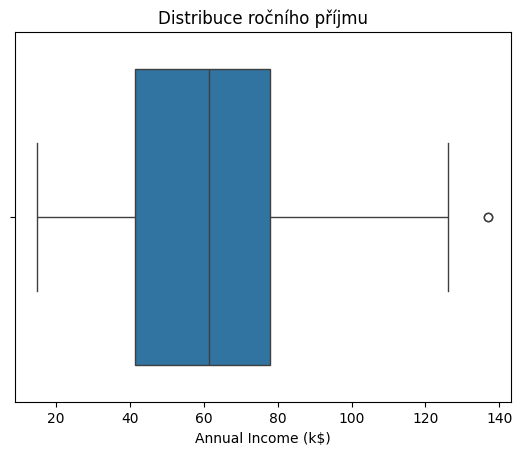

In [167]:
sns.boxplot(x=data['Annual Income (k$)'])
plt.title('Distribuce ročního příjmu')
plt.show()

# Příprava dat
- ošetření NaN hodnot
- encodování textových sloupců

In [168]:
data=data.dropna()

In [169]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Gender_enc']=label_encoder.fit_transform(data['Gender'])

In [170]:
# Uložení encoderu pro opakované použití
import joblib
joblib.dump(label_encoder, 'classification_encoder.bin', compress=True)

['classification_encoder.bin']

In [171]:
# Budeme používat label encoding a vybereme pouze číselné sloupce
data=data[['CustomerID','Age','Annual Income (k$)','Spending Score (1-100)', 'Gender_enc']]

# Výběr proměnných
- zobrazení vztahů mezi proměnnými (pairplot)
- hledáme kombinaci proměnných, které lze opticky ropzdělit do skupin
- vytvoření X pouze s těmito sloupci

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

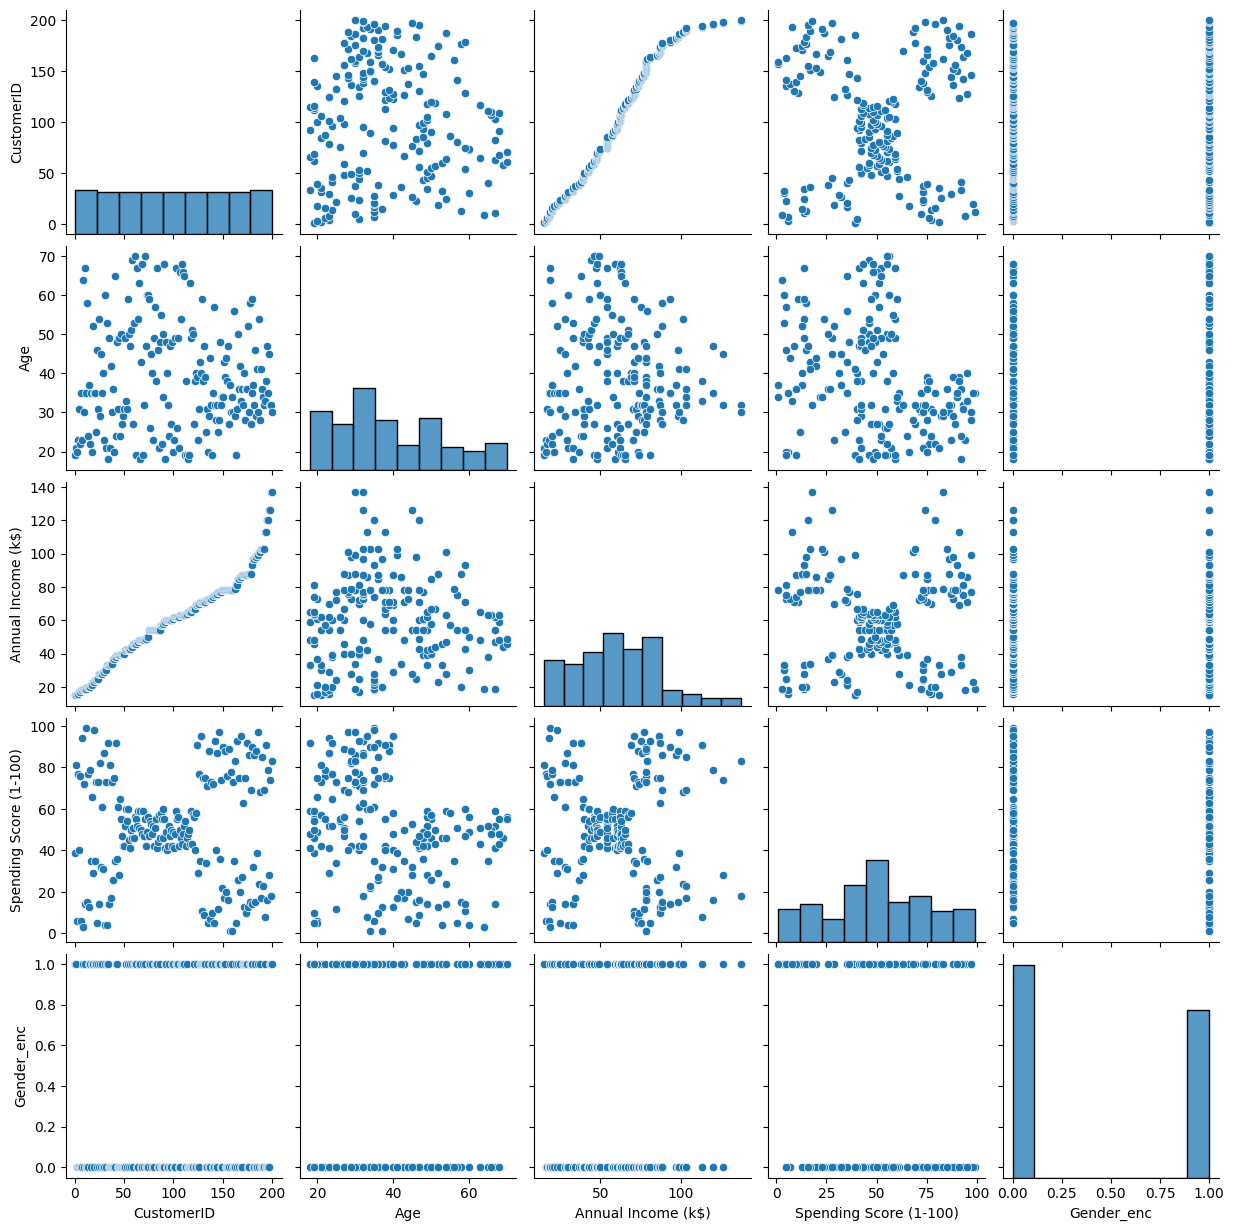

In [173]:
sns.pairplot(data)
plt.show()

<Axes: >

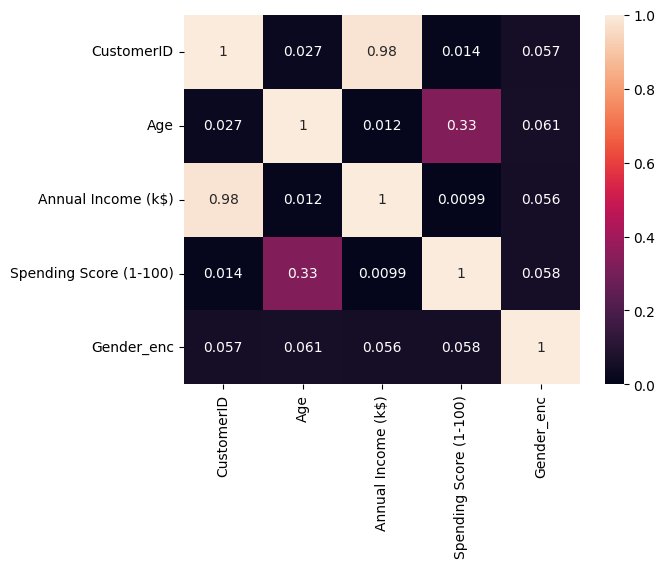

In [174]:
# kovarianční tabulka
corr=data.corr()
sns.heatmap(corr.abs(), annot=True, vmin=0, vmax=1)

In [175]:
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values
Y = data['Gender_enc']

In [176]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [177]:
scaler=StandardScaler()
X_norm=scaler.fit_transform(X)

In [178]:
# natrénovaný scaler si uložíme do souboru
# při hledání druhu kosatce budeme muset vstupní data normalizovat stejně jako jsme je normalizovali během trénování
import joblib
joblib.dump(scaler, 'classification_std_scaler.bin', compress=True)
scaler=joblib.load('classification_std_scaler.bin')

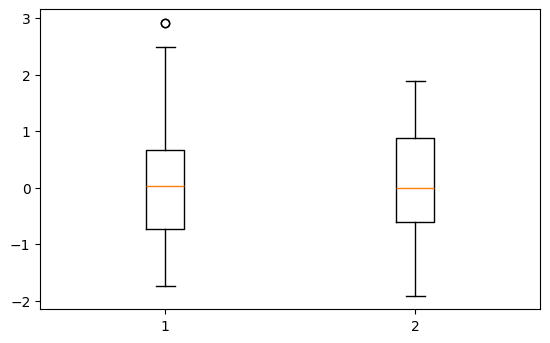

In [179]:
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(X_norm)
plt.show()

In [180]:
X_feature=X[:,0]*X[:,1]

In [181]:
# připravená data si uložení do numpy souboru, abychom tuto činnost nemuseli v dalších noteboocích opakovat
np.savez ("iris_numpy", X, Y, X_norm, X_feature)

# Zjištění parametru modelu k-mean
- vykreslení elbow grafu
- zjištění ideálního počtu clusterů

In [182]:
# načtení dat z numpy souboru
my_arrays = np.load("iris_numpy.npz")
X = my_arrays['arr_0']
Y = my_arrays['arr_1']
X_norm = my_arrays['arr_2']
X_features = my_arrays['arr_3']

In [183]:
# načtení scalar a encoder
import joblib
scaler=joblib.load('classification_std_scaler.bin')
encoder=joblib.load('classification_encoder.bin')

In [184]:
# rozdělení dat na trénovací a testovací
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split (X_norm, Y, test_size=0.2)

In [185]:
# zjištění, kolik segmentů je optimálních
# z analýzy dat víme, že budeme určovat 3

# zkusíme vytvořit model pro více k a budeme sledovat inertia_ 
# inertia_  je součet čtvercových vzdáleností vzorků od jejich nejbližšího středu shluku, vážený váhami vzorků, pokud jsou uvedeny

from sklearn.cluster import KMeans
inertia_list = []
for num_clusters in range(1, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++", n_init = 10)
    kmeans_model.fit(X_norm)
    inertia_list.append(kmeans_model.inertia_)

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

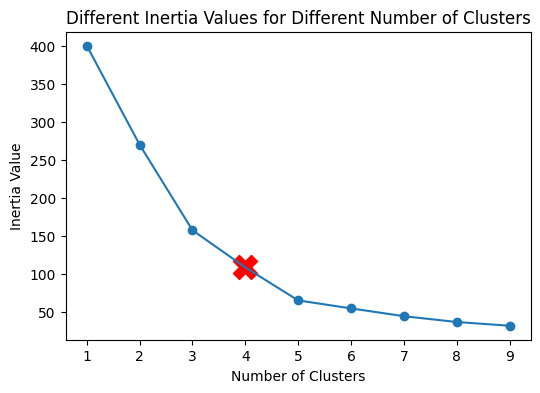

In [186]:
# Vhodné k zjistíme vynesením interial_ do elbow (loket) grafu
# Optimální počet k je v místě, kde se graf naposledy výrazně láme

plt.figure(figsize=(6,4))
plt.plot(range(1,10),inertia_list)
plt.scatter(range(1,10),inertia_list)
plt.scatter(4, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Value")
plt.title("Different Inertia Values for Different Number of Clusters")

# k-mean model pro zjištěný počet clusterů
- natrénování modelu
- predikce dat

In [187]:
# Vytvoření a natrénování k-mean modelu
kmean_model = KMeans(n_clusters=4, random_state= 2, n_init=10)
kmean_model.fit(X_train)

KMeans(n_clusters=4, n_init=10, random_state=2)

In [188]:
# Přidáme čtvrtý cluster, pokud je potřeba
x_new = scaler.transform([[1.4, 0.2]])
y_new = kmean_model.predict(x_new)
setosa_k_id = y_new[0]

x_new = scaler.transform([[4.3, 1.3]])
y_new = kmean_model.predict(x_new)
versicolor_k_id = y_new[0]

x_new = scaler.transform([[5.1, 2.3]])
y_new = kmean_model.predict(x_new)
virginica_k_id = y_new[0]

# Dejme tomu, že čtvrtý cluster je třeba "unknown" nebo jiný typ
x_new = scaler.transform([[6.0, 3.0]])
y_new = kmean_model.predict(x_new)
unknown_k_id = y_new[0]

map_kmeans = [setosa_k_id, versicolor_k_id, virginica_k_id, unknown_k_id]

print(map_kmeans)


[np.int32(3), np.int32(3), np.int32(3), np.int32(3)]


In [189]:
# zobrazení souřadnice center
kmean_model.cluster_centers_

array([[ 1.03289108,  1.19034937],
       [-0.47846558,  0.28555415],
       [ 1.04736914, -1.19382993],
       [-1.28460123, -1.15022738]])

In [190]:
Y_pred_train = kmean_model.predict(X_train)
Y_pred_test = kmean_model.predict(X_test)

In [191]:
# přemapování id clusteru na správné odpovědi label_encode
for i in range(Y_pred_train.shape[0]):
    Y_pred_train[i]=map_kmeans[Y_pred_train[i]]
    
for i in range(Y_pred_test.shape[0]):
    Y_pred_test[i]=map_kmeans[Y_pred_test[i]]    

# Vizualizace modelu
- vykreslení obarvených skupin grafů

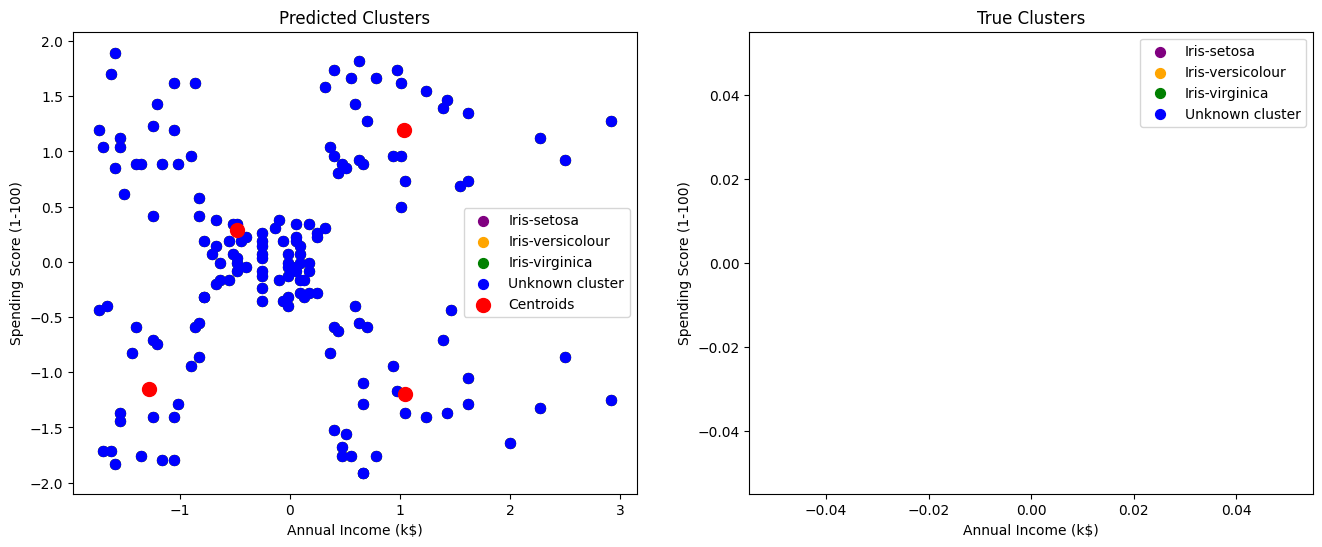

In [193]:
# Trénovací hodnoty
plt.figure(figsize=(16, 6))

# Predikované hodnoty
plt.subplot(1, 2, 1)
plt.scatter(X_train[Y_pred_train == map_kmeans[0], 0], X_train[Y_pred_train == map_kmeans[0], 1], s=50, c='purple', label='Iris-setosa')
plt.scatter(X_train[Y_pred_train == map_kmeans[1], 0], X_train[Y_pred_train == map_kmeans[1], 1], s=50, c='orange', label='Iris-versicolour')
plt.scatter(X_train[Y_pred_train == map_kmeans[2], 0], X_train[Y_pred_train == map_kmeans[2], 1], s=50, c='green', label='Iris-virginica')
plt.scatter(X_train[Y_pred_train == map_kmeans[3], 0], X_train[Y_pred_train == map_kmeans[3], 1], s=50, c='blue', label='Unknown cluster')
plt.title('Predicted Clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

# Centroidy
plt.scatter(kmean_model.cluster_centers_[:, 0], kmean_model.cluster_centers_[:, 1], s=100, c='red', label='Centroids')
plt.legend()

# Skutečné hodnoty
plt.subplot(1, 2, 2)
plt.scatter(X_train[Y_train == map_kmeans[0], 0], X_train[Y_train == map_kmeans[0], 1], s=50, c='purple', label='Iris-setosa')
plt.scatter(X_train[Y_train == map_kmeans[1], 0], X_train[Y_train == map_kmeans[1], 1], s=50, c='orange', label='Iris-versicolour')
plt.scatter(X_train[Y_train == map_kmeans[2], 0], X_train[Y_train == map_kmeans[2], 1], s=50, c='green', label='Iris-virginica')
plt.scatter(X_train[Y_train == map_kmeans[3], 0], X_train[Y_train == map_kmeans[3], 1], s=50, c='blue', label='Unknown cluster')
plt.title('True Clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.legend()
plt.show()

## Výklad modelu
- Popište jednotlivé skupiny
- Na jaké zákazníky se zaměřit?

Popis skupin:
Iris-setosa (purple): Zákazníci s nízkými příjmy a nízkým skóre výdajů. Zaměřte se na cenově dostupné produkty a slevy.
Iris-versicolour (orange): Zákazníci s vyššími příjmy, ale opatrnějšími výdaji. Nabídněte hodnotné produkty za rozumnou cenu.
Iris-virginica (green): Zákazníci s vyššími příjmy a vysokým skóre výdajů. Zaměřte se na prémiové nebo luxusní produkty.
Unknown cluster (blue): Zákazníci s nejednoznačným chováním. Dále analyzujte, abyste zjistili specifika.
Na jaké zákazníky se zaměřit?
Vyšší zisky: Iris-virginica (green) – prémiové produkty.
Masové trhy: Iris-versicolour (orange) – produkty s dobrou hodnotou.
Nízké náklady: Iris-setosa (purple) – cenově dostupné produkty.